In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planets-dataset/planet/planet/sample_submission.csv
/kaggle/input/planets-dataset/planet/planet/train_classes.csv
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_39140.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_4849.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_18979.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_24790.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_30624.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_7922.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_33905.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_15492.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_16642.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_37288.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_9357.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_40104.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_1

In [7]:
import pandas as pd
import numpy as np

# Libraries for Data Visualisation
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Libraries for Loading and Preparing dataset
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from keras import backend
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import os
import time
from sklearn.metrics import fbeta_score
import tensorflow as tf
import sys
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, Input
from keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

from keras import optimizers
from keras.callbacks import EarlyStopping,ModelCheckpoint 
from keras import backend as K 
import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.python import metrics
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical

import gc                             
import cv2
import pickle
from tqdm import tqdm_notebook as tqdm

from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import plotly.tools as tls
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from collections import Counter, defaultdict

print("Setup Completed...!!!")

Setup Completed...!!!


In [8]:
# Loading the train and test datasets

train = '../input/planets-dataset/planet/planet/train_classes.csv'
test = '../input/planets-dataset/planet/planet/sample_submission.csv'

planet_df_train = pd.read_csv(train)
planet_df_test = pd.read_csv(test)

planet_test_image = '../input/planets-dataset/planet/planet/test-jpg/'
planet_train_image = '../input/planets-dataset/planet/planet/train-jpg/'

In [9]:
planet_df_train.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [10]:
planet_df_test.head()

image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water

In [11]:
print('There are Total of {} images contains in train_classes.csv file'.format(len(planet_df_train)))

There are Total of 40479 images contains in train_classes.csv file


In [12]:
print("There are {} rows and {} columns in the train_classes.csv.".format(planet_df_train.shape[0], planet_df_train.shape[1]))

There are 40479 rows and 2 columns in the train_classes.csv.


In [13]:
tags = planet_df_train['tags'].apply(lambda x: x.split(' '))

In [14]:
all_tags = [item for sublist in list(planet_df_train['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]

all_tags[:7]

['haze', 'primary', 'agriculture', 'clear', 'primary', 'water', 'clear']

In [15]:
print('There are total of {} non-unique tags in all training images'.format(len(all_tags)))

print('The average number of tags per image is {}'.format(1.0*len(all_tags)/planet_df_train.shape[0]))

There are total of 116278 non-unique tags in all training images
The average number of tags per image is 2.8725511993873365


In [16]:
def fetch_image_tag(img):
    
    tags = planet_df_train[planet_df_train['image_name'] == img]['tags'].values
    
    return tags[0]

In [17]:
planet_df_train[planet_df_train['image_name'] == 'train_558']

image_name           tags
558  train_558  clear primary

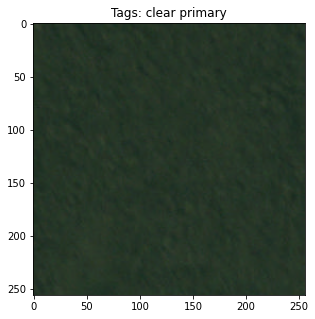

In [18]:
plt.figure(figsize=(8,5))
filename = planet_train_image + 'train_558.jpg'
image = imread(filename)   # load image pixels
pyplot.imshow(image)       # plot the image
plt.title('Tags: ' + fetch_image_tag('train_558'))
pyplot.show()

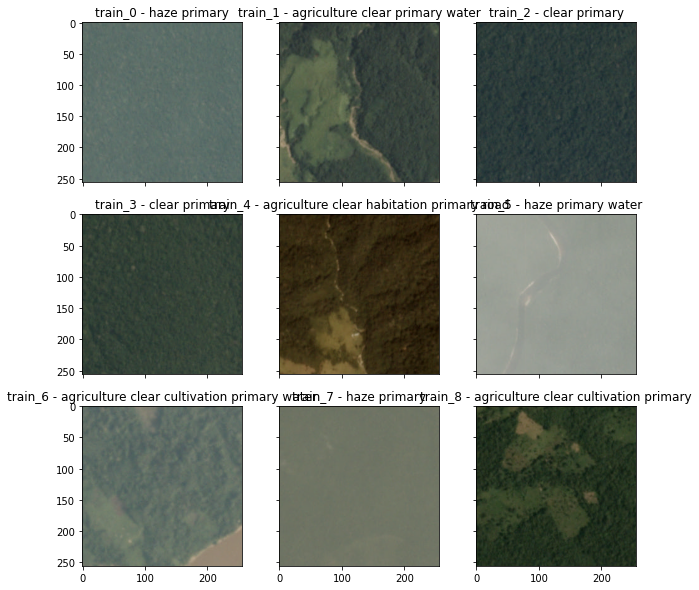

In [19]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(10, 10))
i = 0
for f, l in planet_df_train[:9].values:
    #img = io.imread(folder)
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    i += 1
    
plt.show()

In [20]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list (set(flatten([l.split (' ') for l in planet_df_train['tags'].values])))

In [21]:
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}
label_map

{'clear': 0,
 'water': 1,
 'bare_ground': 2,
 'cloudy': 3,
 'selective_logging': 4,
 'agriculture': 5,
 'blooming': 6,
 'road': 7,
 'partly_cloudy': 8,
 'primary': 9,
 'haze': 10,
 'conventional_mine': 11,
 'artisinal_mine': 12,
 'habitation': 13,
 'slash_burn': 14,
 'cultivation': 15,
 'blow_down': 16}

In [22]:
gc.collect()

56

In [23]:
x_train= []
y_train= []
for img, label in tqdm(planet_df_train.values, miniters = 1000):
    target = np.zeros(17)
  
    for tag in label.split(' '):
        target[label_map[tag]]=1
  
    x_train.append(cv2.resize(cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(img)), (64,64)))
    y_train.append(target)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/40479 [00:00<?, ?it/s]

In [24]:
print(len(x_train)) 

40479


In [25]:
gc.collect()

64

In [26]:
x_test = []

for img, label in tqdm(planet_df_test[0:40669].values, miniters=1000):
    fil = cv2.resize(cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(img)), (60, 60))
    x_test.append(fil)

for img, label in tqdm(planet_df_test[40669:].values, miniters=1000):
    fil = cv2.resize(cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img)), (60, 60))
    x_test.append(fil)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/40669 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/20522 [00:00<?, ?it/s]

In [27]:
print("The lenght of x test: ", len(x_test))

The lenght of x test:  61191


In [28]:
gc.collect()

82

In [29]:
x_train = np.array(x_train, np.float16)/250.
y_train = np.array(y_train, np.uint8)
x_test = np.array(x_test, np.float16)/250.

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, train_size = 0.8, shuffle = True, random_state = 42)

In [31]:
print("Training dataset")
print(x_train.shape)
print(y_train.shape)
print("=" * 20)
print("Validation dataset")
print(x_val.shape)
print(y_val.shape)

Training dataset
(32383, 64, 64, 3)
(32383, 17)
Validation dataset
(8096, 64, 64, 3)
(8096, 17)


In [32]:
input_size = 60
input_channels = 3


#define model
cnn_model = Sequential()

#Input layer
cnn_model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))

# CCM_1
cnn_model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

#CCM_2
cnn_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
 
#CCM_3
cnn_model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
 
#CCM_4
cnn_model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# Create a feature vector from the CCM_4 final layer
cnn_model.add(Flatten())

# Fully Connected (FC) Layer
cnn_model.add(Dense(512, activation='relu'))
cnn_model .add(BatchNormalization())
cnn_model.add(Dropout(0.5))

# Output layer
cnn_model.add(Dense(17, activation='sigmoid'))

2022-09-20 22:46:38.415673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 22:46:38.496592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 22:46:38.497476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 22:46:38.499324: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [33]:
base_model = VGG16(input_shape =(input_size,input_size,3),include_top =False,weights ='imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 60, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 60, 60, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 60, 60, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 30, 30, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 30, 30, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 30, 30, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 15, 15, 128)       0     

In [34]:
x = base_model.output
# Flatten to obtain a feature vector
x = Flatten()(x)
# Connect the feature vector to to the fully connected (FC) layer
x = Dense(512 , activation ='relu')(x)
# Form the output label predictions
predictions = Dense (17 , activation ='sigmoid')(x)
cnn_model = Model(inputs= base_model.input,outputs = predictions)

In [35]:
gc.collect()

2379

In [36]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2
 
    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [37]:
gc.collect()

23

In [38]:
Generator_Image = ImageDataGenerator ( horizontal_flip =True , vertical_flip =True, 
                              zoom_range =0.2, rotation_range =90, 
                              fill_mode ='reflect')

#Other parameters
epochs = 20 
opt = keras.optimizers.Adam(learning_rate=0.0001)

#model compiling
cnn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[fbeta])

callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=2)]

In [39]:
gc.collect()

23

In [43]:
# Let fit the model. The code below fits the model while generating extra images due to the Imagedatagenerator and fitting them on the fly!

cnn_model.fit(Generator_Image.flow(x_train, y_train, batch_size = 32), 
                    steps_per_epoch =len(x_train)/32, validation_data = Generator_Image.flow (x_val, y_val, batch_size =32),
                    validation_steps =len(x_val)/32, epochs =epochs, callbacks = callbacks, verbose = 2)

Epoch 1/20


2022-09-20 22:50:08.249630: W tensorflow/core/framework/op_kernel.cc:1680] Invalid argument: required broadcastable shapes
2022-09-20 22:50:08.251167: W tensorflow/core/framework/op_kernel.cc:1680] Invalid argument: required broadcastable shapes
2022-09-20 22:50:08.251649: W tensorflow/core/framework/op_kernel.cc:1680] Invalid argument: required broadcastable shapes
2022-09-20 22:50:08.251736: W tensorflow/core/framework/op_kernel.cc:1680] Invalid argument: required broadcastable shapes


InvalidArgumentError:  required broadcastable shapes
	 [[node binary_crossentropy/logistic_loss/mul (defined at tmp/ipykernel_2020/4104310757.py:8) ]] [Op:__inference_train_function_2182]

Function call stack:
train_function


In [44]:
gc.collect()

1022

In [ ]:
test_predict =[]
test_predict.append (cnn_model.predict (x_test , batch_size = 20 , verbose =2))

In [2]:
result = np.array (test_predict[0])
for i in range (1,len(test_predict) ):
    result += np. array (test_predict)

result = pd.DataFrame (result,columns = labels )
result

NameError: name 'np' is not defined